# Imports

In [278]:
%matplotlib inline
import novosparc
import os
import numpy as np
import pandas as pd
import pickle
import itertools
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

import labeltransfer_functions as lt

# Load data
## get tissue

In [264]:
data_dir = "data/output"
tissue_file = os.path.join(data_dir,"tissue_maxCells1000_loc500.pkl")
# tissue_file = os.path.join(data_dir,"tissue_maxCells10000_loc10000.pkl") # this looks crazy and not quite right
# tissue_file = os.path.join(data_dir,"tissue_maxCells5000_loc2000.pkl")
# tissue_file = os.path.join(data_dir,"tissue_maxCells5000_loc2000_run2.pkl")
# tissue_file = os.path.join(data_dir,"tissue_maxCells5000_loc2000_run4.pkl")
#read the pickle file
picklefile = open(tissue_file, 'rb')
#unpickle the dataframe
tissue = pickle.load(picklefile)
#close file
picklefile.close()

#print the dataframe
print(type(tissue))
print(tissue.sdge.shape)
print(tissue.gw.shape)

locations = tissue.locations
gene_names = tissue.gene_names

<class 'novosparc.common._tissue.Tissue'>
(3000, 500)
(939, 500)


## get atlas for comparison

In [265]:
data_raw = "data"
atlas_path = os.path.join(data_raw, 'TNBC_atlas_OvrlbAtlasMarkerSnGenes.zip') # use pickle to load
atlas_rdn = pd.read_pickle(atlas_path)
atlas = ad.AnnData(atlas_rdn)

atlas_genes = atlas.var.index.tolist()
target_space_path = os.path.join(data_raw, 'TNBC_6w_fc51_4_coordinates.csv')  # location coordinates
locations_rdn = pd.read_csv(target_space_path, sep=',')
num_locations = locations_rdn.shape[0] # coming from the spatial data #
locations_apriori = locations_rdn[:num_locations][['xcoord', 'ycoord']].values
atlas_locations = locations_apriori

atlas.obsm['spatial'] = atlas_locations

<ipython-input-265-3037dd198c6a>:4: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.

/home/vschuma/miniconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



In [266]:
len(atlas_genes)

400

## get metadata
### atlas annotations

In [267]:
atlas_anno = pd.read_csv('data/TNBC_meta_spatial_annotation_1.csv')
print(atlas_anno.shape) # locations

(55478, 1)


### snRNA annoations

In [268]:
snRNA_anno_global = pd.read_csv('data/TNBC_meta_snRNA_reannotationglobal.csv')
snRNA_anno_phase = pd.read_csv('data/TNBC_meta_snRNA_phase.csv')
print(snRNA_anno_phase.shape) # cells

(26978, 1)


# Check reconstruction
## plot the reconstruction

In [269]:
pl_genes = list(atlas_genes[10:16])

In [270]:
pl_genes

['Eln', 'Fn1', 'Svep1', 'Ltf', 'Aqp1', 'Tph1']

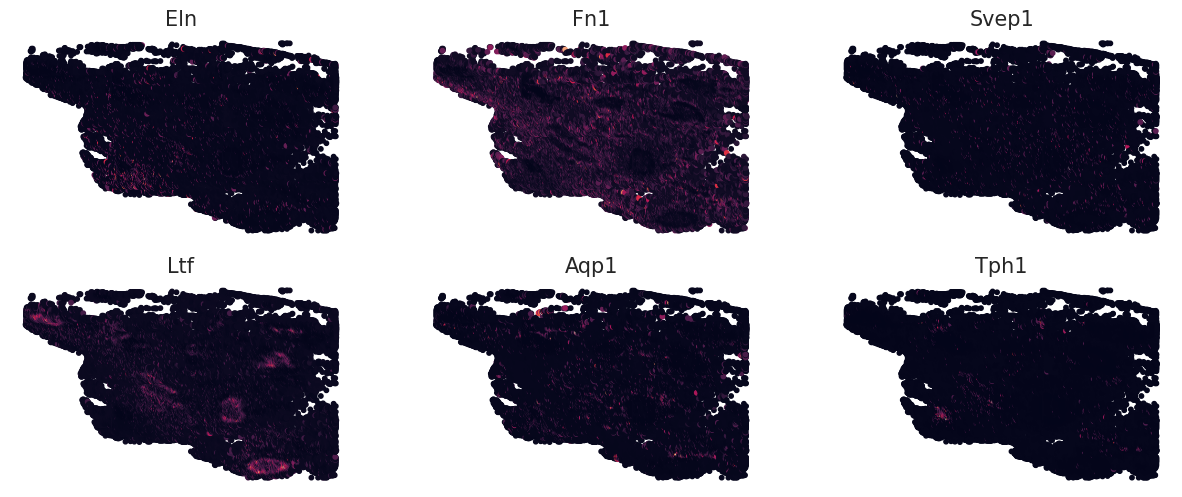

<Figure size 432x288 with 0 Axes>

In [271]:
novosparc.pl.embedding(atlas,pl_genes)

/home/vschuma/miniconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



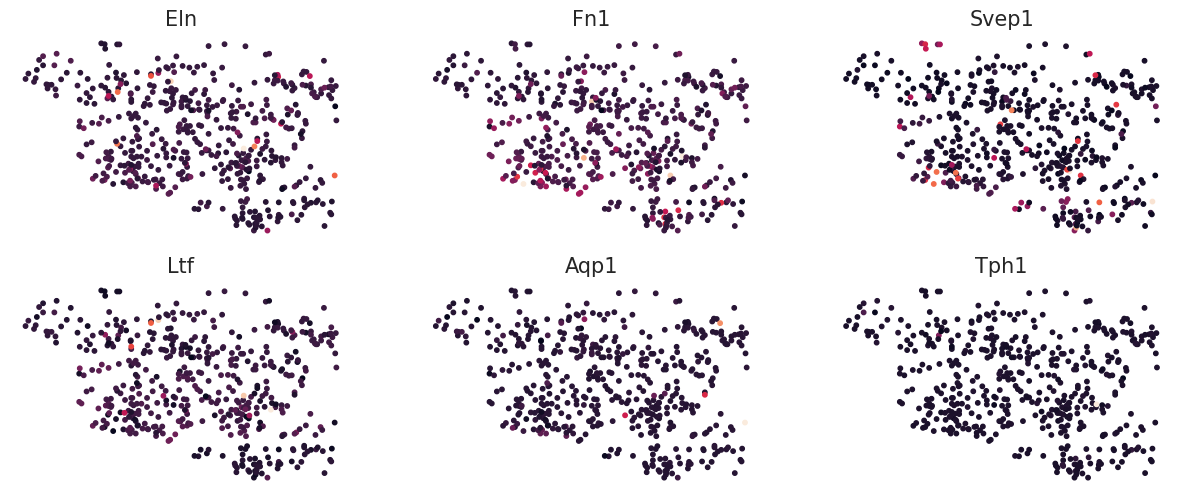

<Figure size 432x288 with 0 Axes>

In [272]:
# create
dataset_tissue = sc.AnnData(pd.DataFrame(tissue.sdge.T, columns = gene_names), dtype=float)
dataset_tissue.obsm['spatial'] = locations
novosparc.pl.embedding(dataset_tissue, pl_genes)

## get annotations for the subsampled locations

In [273]:
# get the location indexes that are used in the subsample from the complete location list
atlas_locations = pd.DataFrame(atlas_locations)
idx_list = []
for index, row in pd.DataFrame(tissue.locations).iterrows():
    x = tissue.locations[index][0]
    y = tissue.locations[index][1]
    loc_idx = locations_rdn.index[(locations_rdn['xcoord']==x) &
                              (locations_rdn['ycoord']==y)].tolist()
    idx_list.append(loc_idx)
    list_of_used_locations = list(itertools.chain(*idx_list))
print(len(list_of_used_locations))

# subset atlas annotations accordingly
atlas_anno_subset = atlas_anno.loc[list_of_used_locations,:]

500


## get annotations for subampled cells

!!! Something is not matching up with the column order I think. I should be able to get a full subsample of each column, based on the same column index. But for some reason this is not possible

In [274]:
dataset_path = os.path.join(data_raw, 'TNBC_sn_integrated_dge.zip')  # use pickle to load
print("Reading in dge")
dataset_rdn = pd.read_pickle(dataset_path)
print("convert dge to anndata")
dataset = ad.AnnData(dataset_rdn)

Reading in dge
convert dge to anndata


<ipython-input-274-8b9606b6a547>:5: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.

/home/vschuma/miniconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



In [276]:
selected_cells = pd.read_csv('data/output/tissue_maxCells5000_loc2000_run3_cellsselected.csv').values.tolist()
list_of_used_cells = list(itertools.chain(*selected_cells))
list_of_used_cells = [int(list_of_used_cells) for list_of_used_cells in list_of_used_cells]
list_of_used_cells

[26827,
 24473,
 3578,
 17242,
 6376,
 13444,
 7528,
 5983,
 5649,
 23390,
 15692,
 15739,
 1217,
 11535,
 20670,
 23907,
 22394,
 14111,
 7981,
 6297,
 7701,
 12326,
 9048,
 24466,
 11679,
 23103,
 1580,
 24301,
 14016,
 14782,
 2996,
 11242,
 23249,
 8203,
 17086,
 19567,
 26726,
 25887,
 5196,
 22725,
 19535,
 6310,
 6134,
 16146,
 12165,
 2648,
 21146,
 2986,
 13629,
 23911,
 2685,
 25968,
 1272,
 21648,
 13050,
 5689,
 20872,
 2230,
 22735,
 4220,
 19580,
 23894,
 8665,
 23233,
 1963,
 1638,
 15442,
 2892,
 25434,
 7107,
 15056,
 2215,
 23956,
 21507,
 20610,
 20677,
 1441,
 8213,
 7693,
 22766,
 13440,
 237,
 13313,
 6279,
 10157,
 22714,
 13078,
 5643,
 644,
 21869,
 166,
 11608,
 18172,
 17785,
 1369,
 26297,
 26830,
 21197,
 21002,
 5383,
 6746,
 12212,
 22965,
 18398,
 778,
 168,
 6767,
 9434,
 21147,
 8943,
 1259,
 6975,
 15279,
 21075,
 26964,
 2583,
 23819,
 20919,
 12750,
 24668,
 25891,
 23876,
 26117,
 19042,
 559,
 1305,
 19708,
 5046,
 10594,
 24559,
 7603,
 18327,
 2

## subset snRNA annotations accordingly

In [ ]:
snRNA_anno_phase_subsample = snRNA_anno_phase.loc[list_of_used_cells,:]
snRNA_anno_global_subsample = snRNA_anno_global.loc[list_of_used_cells,:]

# Workflow label transfer
## atlas with annotations

In [277]:
atlas_anno = lt.merge_meta_gw(atlas)

In [279]:
atlas

AnnData object with n_obs × n_vars = 55478 × 400
    obsm: 'spatial'

In [280]:
help(lt.merge_meta_gw)

Help on function merge_meta_gw in module labeltransfer_functions:

merge_meta_gw(gw_matrix, meta_matrix)
    gw_matrix - pd.DataFrame, from tissue object (tissue.gw)
    meta_matrix - pd.DataFrame, meta data (x,1), row length (cells?) must match gw_matrix
    output: pd.DataFrame with gw matrix and the meta data labels as column names



In [281]:
tissue.gw.shape # cells x locations

(939, 500)

In [282]:
atlas_anno_subset.shape

(500, 1)

In [283]:
atlas.X.shape

(55478, 400)

In [284]:
n_loc_atlas = 10
atlas_smoll = sc.pp.subsample(atlas, n_obs=n_loc_atlas, copy=True)

In [285]:
help(sc.pp.subsample)

Help on function subsample in module scanpy.preprocessing._simple:

subsample(data: Union[anndata._core.anndata.AnnData, numpy.ndarray, scipy.sparse._base.spmatrix], fraction: Optional[float] = None, n_obs: Optional[int] = None, random_state: Union[NoneType, int, numpy.random.mtrand.RandomState] = 0, copy: bool = False) -> Optional[anndata._core.anndata.AnnData]
    Subsample to a fraction of the number of observations.
    
    Parameters
    ----------
    data
        The (annotated) data matrix of shape `n_obs` × `n_vars`.
        Rows correspond to cells and columns to genes.
    fraction
        Subsample to this `fraction` of the number of observations.
    n_obs
        Subsample to this number of observations.
    random_state
        Random seed to change subsampling.
    copy
        If an :class:`~anndata.AnnData` is passed,
        determines whether a copy is returned.
    
    Returns
    -------
    Returns `X[obs_indices], obs_indices` if data is array-like, otherwise
